# Eigenproblem for the transmon-resonator system

Author: G. P. Fedorov (gleb.fedorov@phystech.edu), https://github.com/vdrhtc/XMons

In [1]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [1]:
def spines():
    pass
    
def annotate_distance(ax, text, point1, point2, linestyle, fontsize, textoffset = (0.1,0)):
    ax.annotate('', point1, point2, \
            arrowprops={'arrowstyle':'<->', 'linestyle':linestyle, "facecolor":"black"}, fontsize=fontsize);
    ax.annotate(text, point1, (0.5*(point1[0]+point2[0])+textoffset[0], 0.5*(point1[1]+point2[1])+textoffset[1]),
                fontsize=fontsize)

In [2]:
from scipy import *
from scipy.constants import e, h, hbar
from qutip import *

Capacitances and other parameters:

In [736]:
font = {"size":17}
matplotlib.rc("font", **font)

In [541]:
C_κ = 0e-15
C_g = 2e-15
C_q = 90e-15
C_r = 251.9e-15*2.028585
L_r = 9.737e-10*2.028585
Φ = 0 # in Φ_0
def C_ast():
    return sqrt(C_q*C_g+C_q*C_κ+C_g*C_κ+C_q*C_r+C_g*C_r)
def E_C():
    return (e)**2*(C_g+C_κ+C_r)/2/C_ast()**2/h/1e9
def E_J():
    return (6e9+E_C()*1e9)**2/8/(e)**2/(C_g+C_κ+C_r)*2*C_ast()**2*h**2/h/1e9*cos(pi*Φ)
def ω_r():
    return 1/sqrt(L_r*C_ast()**2/(C_q+C_g))

In [542]:
E_J()/E_C(), ω_r()/1e9/2/pi

(108.74381893274558, 5.0000048558435708)

In [178]:
N_q = 10
N_r = 5
n_g = 0

In [327]:
def a():
    return destroy(N_r)
def n():
    return Qobj((diag(arange(-N_q, N_q+1, 1))))

def H_q_isolated():
    H_q = 4*E_C()*n()**2+ E_J()/2*(Qobj(diag(ones(2*N_q), 1) + diag(ones(2*N_q), -1)))
    return H_q
def H_q():
    return tensor(identity(N_r), H_q_isolated())

def H_r():
    H_r = ω_r()/2/pi/1e9*(a().dag()*a()+1/2)
    return tensor(H_r, identity(2*N_q+1))
def g():
    return 2*e*C_g/C_ast()*sqrt(hbar*ω_r()/2/(C_q+C_g))/h/1e9
def H_i():
    return g()*1j*tensor(a().dag()-a(), n())

def H():
    return H_q()+H_r()+H_i()

# Eigenenergies and eigenstates

In [734]:
E_0 = H().eigenenergies()[0]
evals = []
Φs = linspace(-2, 2, 1000)
for Φ in Φs:
    evals.append(H().eigenenergies())
evals = array(evals)

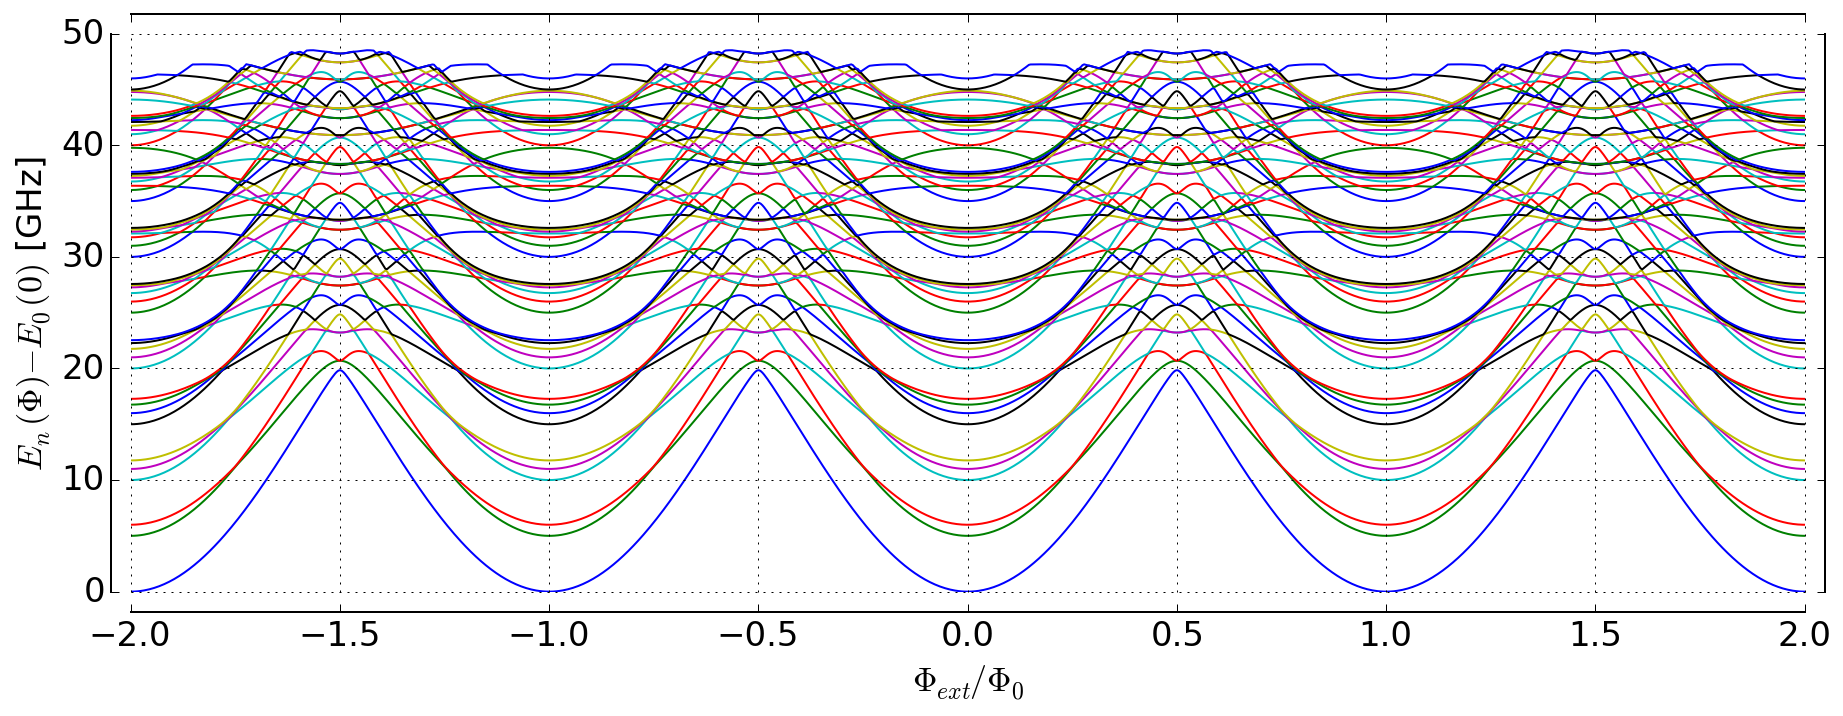

In [755]:
for i in range(0, 50):
    plt.plot(Φs, (evals[:, i]-E_0))
spines()
plt.ylabel("$E_n(\Phi) - E_0(0)$ [GHz]")
plt.xlabel("$\Phi_{ext}/\Phi_0$")
plt.gcf().set_size_inches(15,5)
plt.grid()
plt.savefig("levels.pdf",bbox_inches='tight')

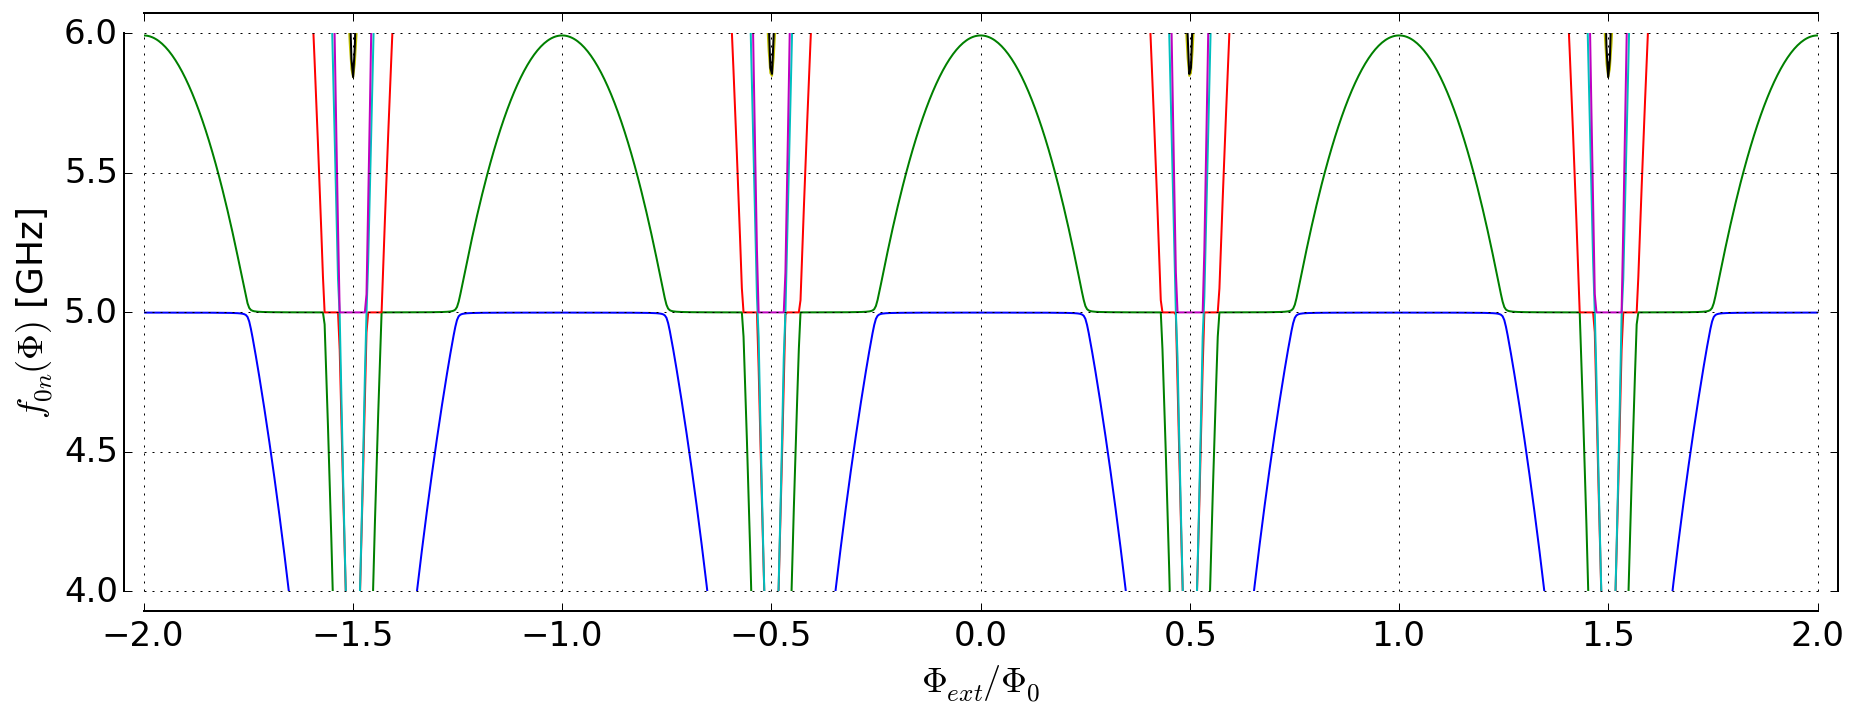

In [750]:
for i in range(1, 20):
    plt.plot(Φs, (evals[:, i]-evals[:,0]))
#plt.xlim(-0.5, 0.5)
plt.ylim(4, 6)
spines()

plt.ylabel("$f_{0n}(\Phi)$ [GHz]", fontsize=18)
plt.xlabel("$\Phi_{ext}/\Phi_0$", fontsize=18)
plt.grid()
plt.gcf().set_size_inches(15,5)
plt.savefig("freqs.pdf", bbox_inches='tight')

#Energy diagram

In [592]:
Φ = 0
N_r = 10
nqs = range(0, 2*N_q+1, 1)
nrs = range(0, N_r, 1)
evecs = H().eigenstates()[1]
E_0 = H().eigenenergies()[0]
evecs_q = H_q_isolated().eigenstates()[1]
colors = ["b", "orange", "green", "red", "black"]

qubit_states_taken = 5

E_rs = zeros((N_r, qubit_states_taken))

for state in evecs:
    found = False
    for n_r in nrs:
        for n_q in nqs[:5]:
            base_vec = tensor(basis(N_r, n_r), evecs_q[n_q])
            if abs((state.dag()*base_vec).data[0,0]) > 0.5:
                E = (state.dag()*H()*state).data[0,0]
                E_rs[n_r, n_q] = real(E)
                #print(abs((state.dag()*base_vec).data[0,0]), n_r, n_q, E-E_0)

                found=True
                continue
        if found: continue

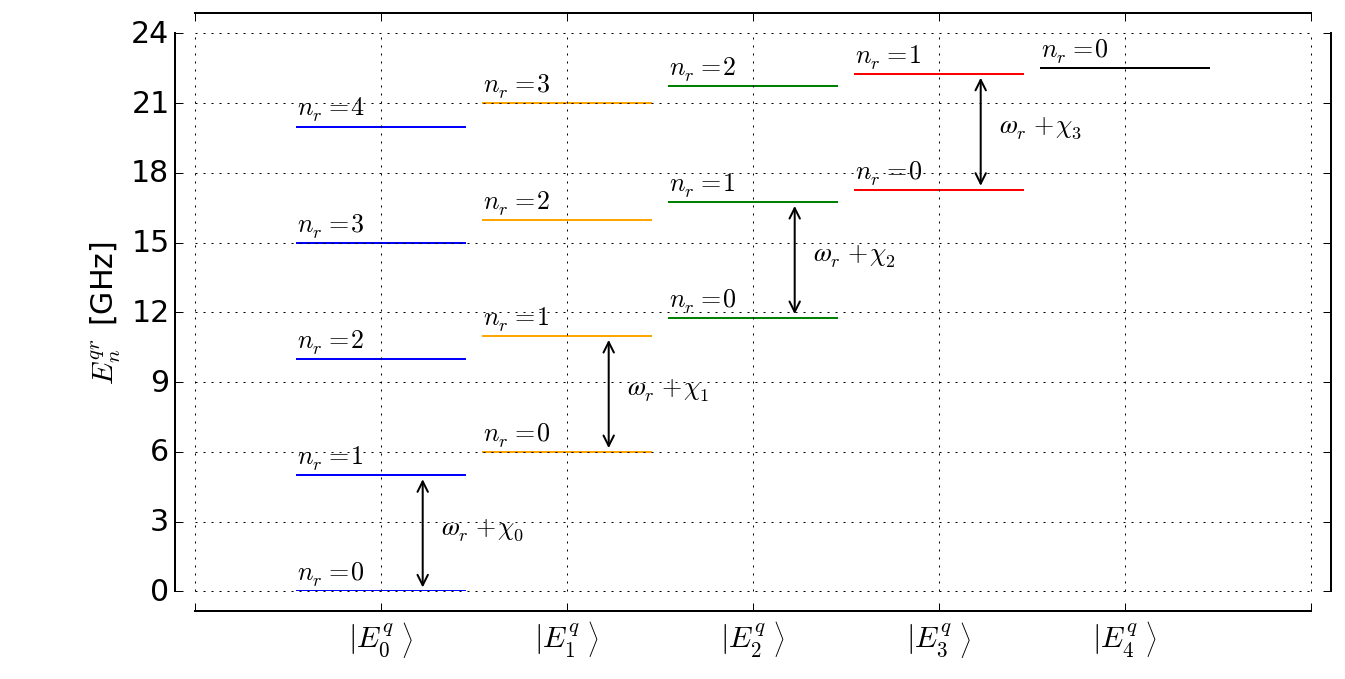

In [595]:
X = array([-0.45, 0.45])

for n_r in nrs:
    for n_q in nqs[:5]:
        plt.plot(X+n_q, ones_like(X)*E_rs[n_r, n_q] - E_0, colors[n_q])
        plt.annotate("$n_r=%i$"%n_r, (X[0]+n_q, E_rs[n_r, n_q] - E_0+0.5),
                     (X[0]+n_q, E_rs[n_r, n_q] - E_0+0.5), fontsize=13)
        if n_r==1 and n_q<4:
            annotate_distance(plt.gca(), "$ω_r + \chi_%i$"%n_q, 
                              (n_q+X[-1]/2, E_rs[n_r-1, n_q] - E_0), (n_q+X[-1]/2, E_rs[n_r, n_q] - E_0), None, 13)
        
spines()
plt.gcf().set_size_inches(10, 5)
plt.ylim(0, 24)
plt.xticks(linspace(-1, 5, 7))
plt.yticks(linspace(0, 24, 9))
plt.gca().set_xticklabels([""]+[r"$\left.|E^q_%i\right>$"%i for i in range(0,5)])
plt.ylabel("$E^{qr}_n$ [GHz]")
plt.grid()



plt.savefig("diagram.pdf", format="pdf")

In [533]:
evecs[11].dag()*tensor(basis(N_r, 3), evecs_q[2])

Quantum object: dims = [[1], [1]], shape = [1, 1], type = oper, isherm = True
Qobj data =
[[ 0.]]

In [438]:
evals = []
Φs = linspace(-0.01, 0.01, 500)
for Φ in Φs:
    evals.append(H().eigenenergies())
evals = array(evals)

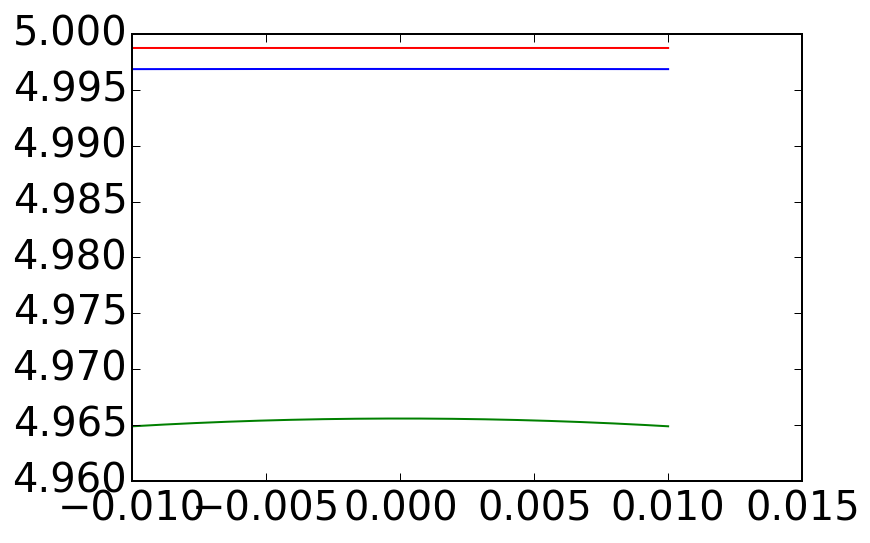

In [439]:
plt.plot(Φs, evals[:, 4] - evals[:, 2])
plt.plot(Φs, evals[:, 8] - evals[:,5])
plt.plot(Φs, evals[:, 1] - evals[:,0])

# Perturbation theory

In [623]:
Φ=0
evals_unpert, evecs_unpert = (H_q() + H_r()).eigenstates()
evals, evecs = (H_q() + H_r()+H_i()).eigenstates()
evals_q, evecs_q = H_q_isolated().eigenstates()
evals_q = evals_q - evals_q[0]

In [615]:
def second_order_correction_to(i, H_p, evals_unpert):
    return sum([abs(evecs_unpert[i].dag()*H_p*evecs_unpert[j])**2/
                (evals_unpert[i]-evals_unpert[j]) if j!=i else 0 for j in range(0, len(evals_unpert))])


In [728]:
N = 5
soc = second_order_correction_to(N, H_i(), (H_q() + H_r()).eigenenergies()[:])

In [729]:
soc.data[0], evals[N] - evals_unpert[N]

(0.0014337971846884118, 0.0014319799982054349)

In [731]:
(second_order_correction_to(8, H_i(), (H_q() + H_r()).eigenenergies()[:]) -\
second_order_correction_to(5, H_i(), (H_q() + H_r()).eigenenergies()[:])).data[0]

-0.0018424540282695337

In [699]:
(abs(evecs_unpert[4].dag()*H_i()*evecs_unpert[12])**2/\
                (evals_unpert[4]-evals_unpert[12])).data[0]

-0.00022677277350794219

In [702]:
(abs(evecs_unpert[2].dag()*H_i()*evecs_unpert[8])**2/\
                (evals_unpert[2]-evals_unpert[8])).data[0]

-0.00011338638675397116

### Formulas testing

$\chi_0$:

In [618]:
evals[1] - evals[0] - ω_r()/2/pi/1e9

-0.00069711643876768647

In [725]:
(g()**2*abs(evecs_q[1].dag()*n()*evecs_q[0])**2/(ω_r()/2/pi/1e9-evals_q[1])\
+g()**2*abs(evecs_q[1].dag()*n()*evecs_q[0])**2/(-ω_r()/2/pi/1e9-evals_q[1])).data[0]

-0.00069747124205379115

$\chi_1$:

In [620]:
evals[4] - evals[2] - ω_r()/2/pi/1e9

-0.0010151548399006671

In [714]:
(g()**2*(evecs_q[1].dag()*n()*evecs_q[0])**2/(ω_r()/2/pi/1e9+evals_q[1]) + \
g()**2*(evecs_q[1].dag()*n()*evecs_q[2])**2/(ω_r()/2/pi/1e9+evals_q[1] - evals_q[2]) +\
g()**2*(evecs_q[1].dag()*n()*evecs_q[0])**2/(-ω_r()/2/pi/1e9+evals_q[1]) + \
g()**2*(evecs_q[1].dag()*n()*evecs_q[2])**2/(-ω_r()/2/pi/1e9+evals_q[1] - evals_q[2])).data[0,0]

(-0.0010164370761901217+0j)

$\chi_2$:

In [705]:
evals[8] - evals[5] - ω_r()/2/pi/1e9

-0.0018340814845183573

In [733]:
(g()**2*(evecs_q[2].dag()*n()*evecs_q[1])**2/(ω_r()/2/pi/1e9+evals_q[2]-evals_q[1]) + \
g()**2*(evecs_q[2].dag()*n()*evecs_q[3])**2/(ω_r()/2/pi/1e9+evals_q[2] - evals_q[3]) +\
g()**2*(evecs_q[2].dag()*n()*evecs_q[1])**2/(-ω_r()/2/pi/1e9+evals_q[2]-evals_q[1]) + \
g()**2*(evecs_q[2].dag()*n()*evecs_q[3])**2/(-ω_r()/2/pi/1e9+evals_q[2] - evals_q[3])).data[0,0]

(-0.0018418435253047889+0j)

# Cooper pair distribution in transmon eigenstates

In [389]:
Φ=0
N = 2
nqs = range(0, 2*N_q+1, 1)
vals = []
for i in nqs:
    vals.append(real((evecs_unpert[N].dag()*tensor(basis(N_r, 0), basis(2*N_q+1, i)))[0,0]))

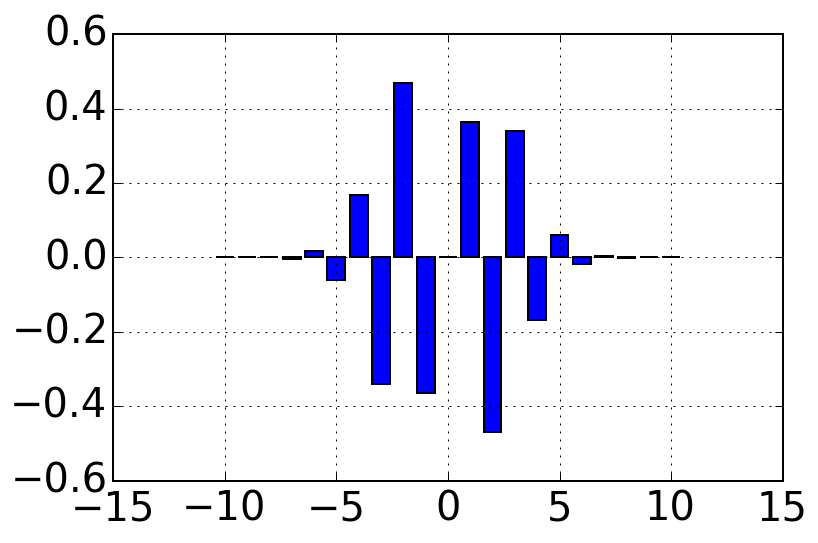

In [390]:
plt.bar(array(nqs)-N_q-0.4, vals)
plt.grid()

In [726]:
i = 2
mes = []
for j in range(0, 15):
    mes.append((evecs_q[i].dag()*n()*evecs_q[j]).data[0,0])
mes = array(mes)

(-1, 15)

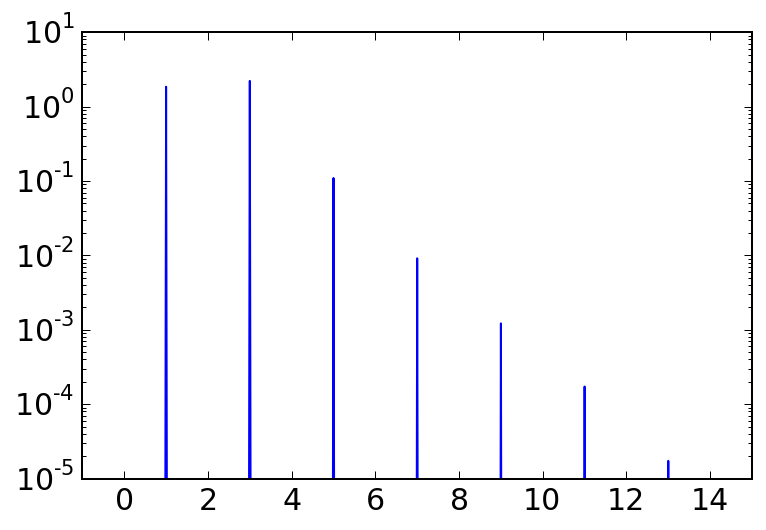

In [727]:
plt.plot(abs(mes))
plt.yscale("log")
plt.xlim(-1,15)